In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('../data/customer_data.csv')

print("="*70)
print("DBSCAN CLUSTERING ANALYSIS")
print("="*70)
print(f"\n✅ Loaded {len(df):,} customer records")

# Select features for clustering (same as K-Means)
features_for_clustering = [
    'Annual_Income', 
    'Spending_Score', 
    'Total_Purchases', 
    'Avg_Transaction_Value', 
    'Tenure_Months', 
    'Website_Visits_Monthly', 
    'Email_Open_Rate'
]

X = df[features_for_clustering]

print(f"\n📊 Features used for clustering: {len(features_for_clustering)}")
for i, feature in enumerate(features_for_clustering, 1):
    print(f"   {i}. {feature}")

DBSCAN CLUSTERING ANALYSIS

✅ Loaded 50,000 customer records

📊 Features used for clustering: 7
   1. Annual_Income
   2. Spending_Score
   3. Total_Purchases
   4. Avg_Transaction_Value
   5. Tenure_Months
   6. Website_Visits_Monthly
   7. Email_Open_Rate


In [3]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n" + "="*70)
print("DATA STANDARDIZATION")
print("="*70)
print("✅ Features standardized for DBSCAN")
print(f"Shape: {X_scaled.shape}")


DATA STANDARDIZATION
✅ Features standardized for DBSCAN
Shape: (50000, 7)



FINDING OPTIMAL EPSILON (eps) PARAMETER

📊 Using MinPts = 14 (2 * number of features)


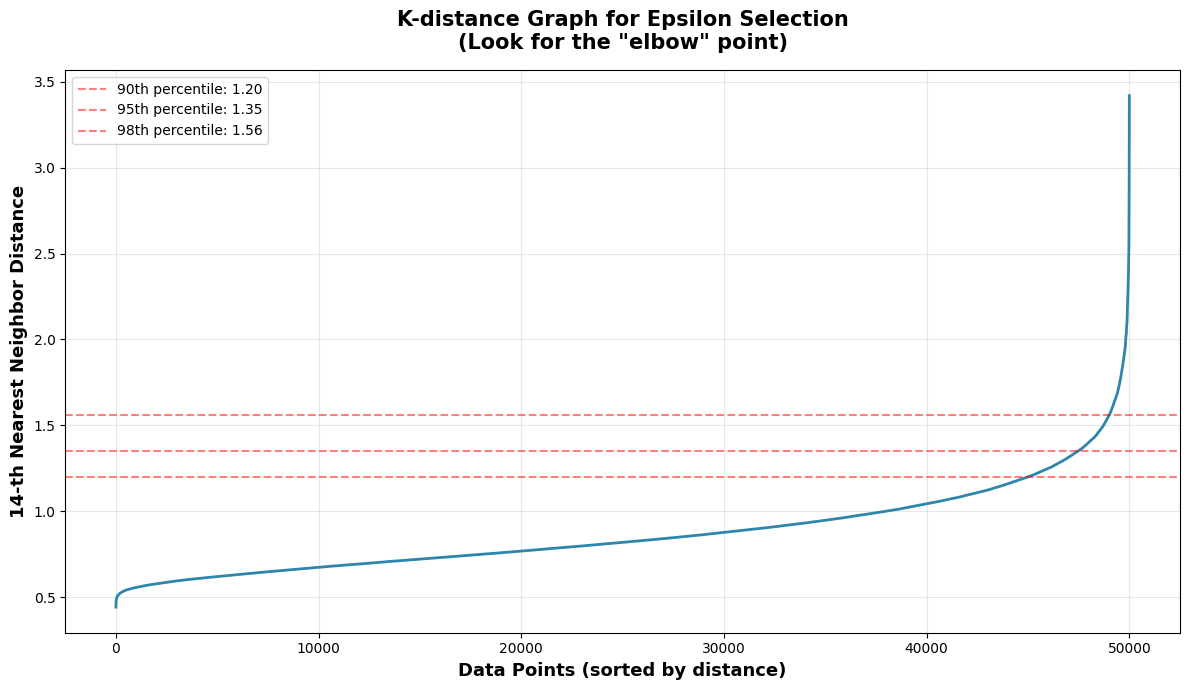


✅ Saved: visualization/kdistance_graph.png

💡 Tip: Choose eps around the 'elbow' point where distance increases sharply


In [4]:
# Finding optimal epsilon using K-distance graph
print("\n" + "="*70)
print("FINDING OPTIMAL EPSILON (eps) PARAMETER")
print("="*70)

# Use MinPts = 2 * dimensions (rule of thumb)
k = 2 * len(features_for_clustering)  # MinPts
print(f"\n📊 Using MinPts = {k} (2 * number of features)")

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances for k-th nearest neighbor
distances = np.sort(distances[:, k-1], axis=0)

# Plot K-distance graph
plt.figure(figsize=(12, 7))
plt.plot(distances, linewidth=2, color='#2E86AB')
plt.xlabel('Data Points (sorted by distance)', fontsize=13, fontweight='bold')
plt.ylabel(f'{k}-th Nearest Neighbor Distance', fontsize=13, fontweight='bold')
plt.title('K-distance Graph for Epsilon Selection\n(Look for the "elbow" point)', 
          fontsize=15, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3)

# Add horizontal lines at key distances
percentiles = [90, 95, 98]
for p in percentiles:
    val = np.percentile(distances, p)
    plt.axhline(y=val, color='red', linestyle='--', alpha=0.5, 
                label=f'{p}th percentile: {val:.2f}')

plt.legend()
plt.tight_layout()
plt.savefig('../visualization/kdistance_graph.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✅ Saved: visualization/kdistance_graph.png")
print(f"\n💡 Tip: Choose eps around the 'elbow' point where distance increases sharply")

In [6]:
# Test different parameter combinations
print("\n" + "="*70)
print("TESTING DIFFERENT DBSCAN PARAMETERS")
print("="*70)

eps_values = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
min_samples_values = [10, 15, 20]

results = []

print("\nTesting parameter combinations...")
print("-" * 70)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_pct = (n_noise / len(labels)) * 100
        
        # Calculate silhouette only if we have more than 1 cluster and not all noise
        if n_clusters > 1 and n_noise < len(labels):
            mask = labels != -1
            if sum(mask) > n_clusters:  # Need more samples than clusters
                silhouette = silhouette_score(X_scaled[mask], labels[mask])
            else:
                silhouette = -1
        else:
            silhouette = -1
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': noise_pct,
            'silhouette': silhouette
        })
        
        print(f"eps={eps:.1f}, min_samples={min_samples:2d} → "
              f"Clusters={n_clusters}, Noise={n_noise:5d} ({noise_pct:5.1f}%), "
              f"Silhouette={silhouette:6.3f}")

print("\n✅ Parameter testing complete!")


TESTING DIFFERENT DBSCAN PARAMETERS

Testing parameter combinations...
----------------------------------------------------------------------
eps=0.5, min_samples=10 → Clusters=58, Noise=47925 ( 95.9%), Silhouette=-0.144
eps=0.5, min_samples=15 → Clusters=13, Noise=49708 ( 99.4%), Silhouette= 0.241
eps=0.5, min_samples=20 → Clusters=0, Noise=50000 (100.0%), Silhouette=-1.000
eps=0.7, min_samples=10 → Clusters=23, Noise=23237 ( 46.5%), Silhouette=-0.177
eps=0.7, min_samples=15 → Clusters=8, Noise=28214 ( 56.4%), Silhouette=-0.140
eps=0.7, min_samples=20 → Clusters=4, Noise=32028 ( 64.1%), Silhouette=-0.016
eps=0.9, min_samples=10 → Clusters=3, Noise= 7501 ( 15.0%), Silhouette= 0.144
eps=0.9, min_samples=15 → Clusters=2, Noise= 9693 ( 19.4%), Silhouette= 0.252
eps=0.9, min_samples=20 → Clusters=2, Noise=11599 ( 23.2%), Silhouette= 0.388
eps=1.1, min_samples=10 → Clusters=1, Noise= 2206 (  4.4%), Silhouette=-1.000
eps=1.1, min_samples=15 → Clusters=1, Noise= 3013 (  6.0%), Silhouette=-1.

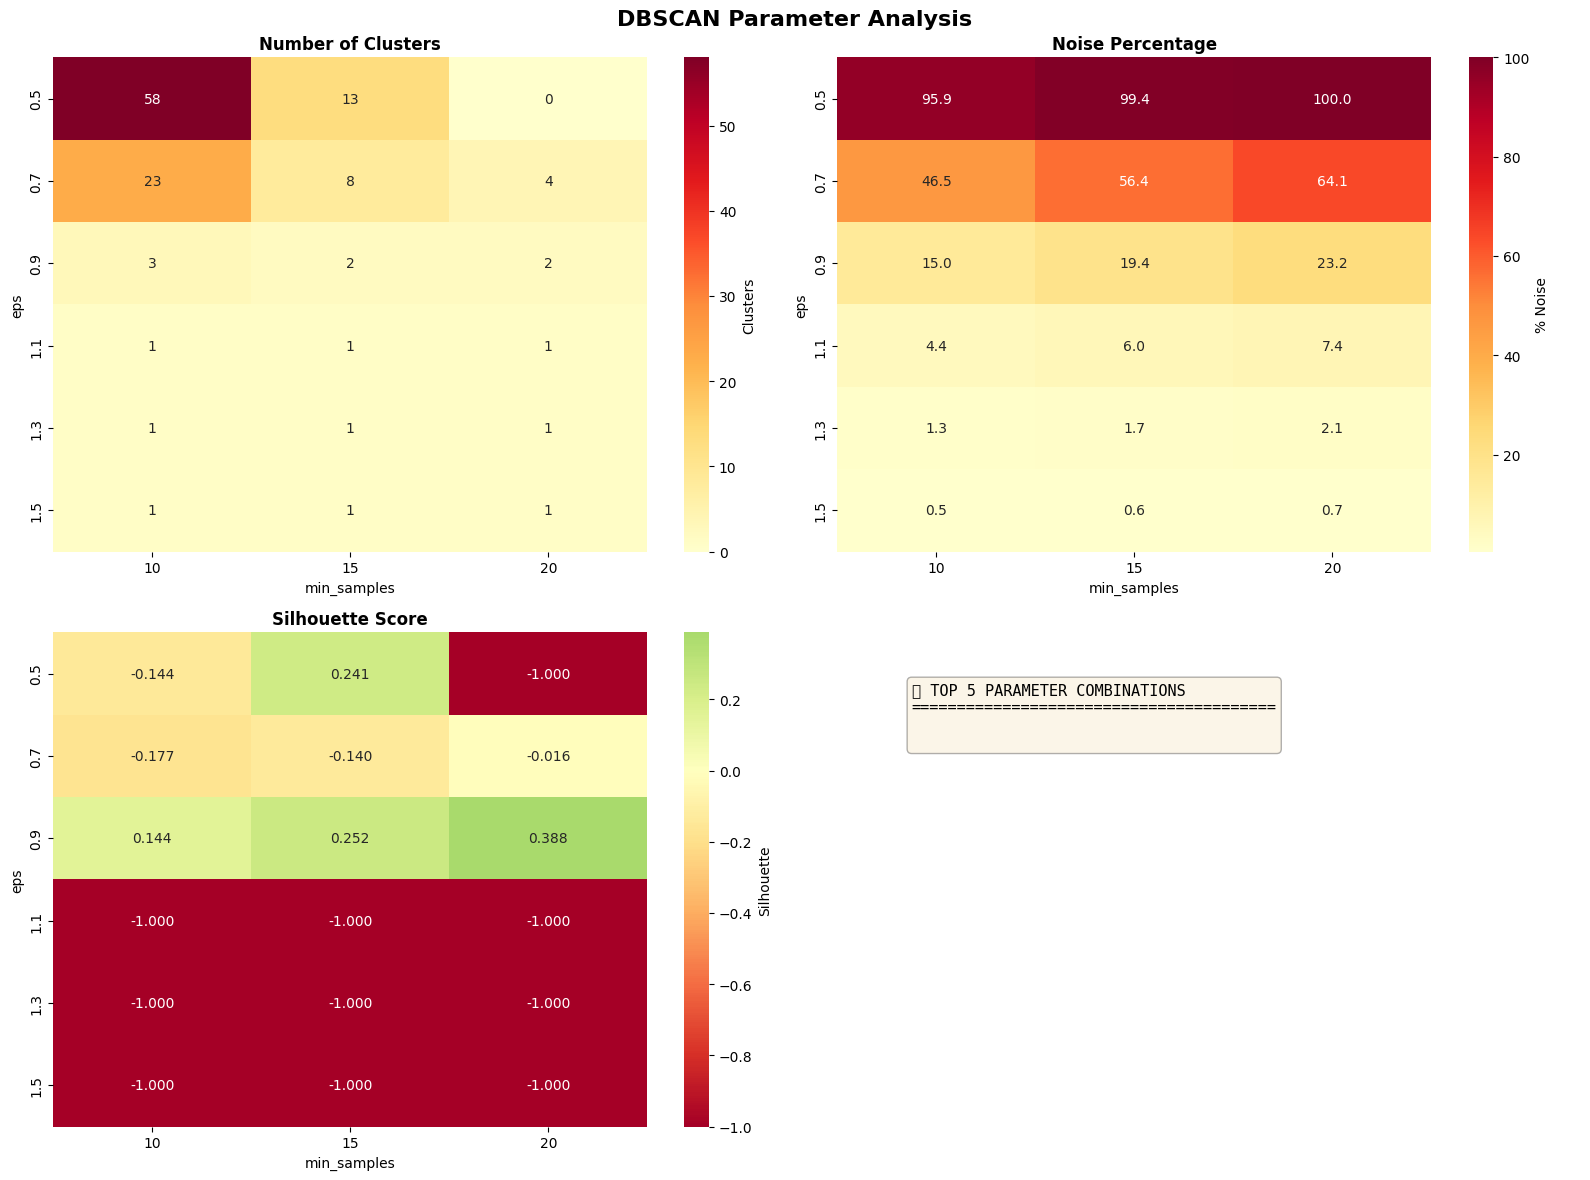


✅ Saved: visualization/dbscan_parameter_analysis.png


In [7]:
# Visualize results
results_df = pd.DataFrame(results)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DBSCAN Parameter Analysis', fontsize=16, fontweight='bold')

# Plot 1: Number of Clusters
pivot_clusters = results_df.pivot(index='eps', columns='min_samples', values='n_clusters')
sns.heatmap(pivot_clusters, annot=True, fmt='g', cmap='YlOrRd', ax=axes[0, 0], cbar_kws={'label': 'Clusters'})
axes[0, 0].set_title('Number of Clusters', fontweight='bold')
axes[0, 0].set_xlabel('min_samples')
axes[0, 0].set_ylabel('eps')

# Plot 2: Noise Percentage
pivot_noise = results_df.pivot(index='eps', columns='min_samples', values='noise_pct')
sns.heatmap(pivot_noise, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0, 1], cbar_kws={'label': '% Noise'})
axes[0, 1].set_title('Noise Percentage', fontweight='bold')
axes[0, 1].set_xlabel('min_samples')
axes[0, 1].set_ylabel('eps')

# Plot 3: Silhouette Score
pivot_silhouette = results_df.pivot(index='eps', columns='min_samples', values='silhouette')
sns.heatmap(pivot_silhouette, annot=True, fmt='.3f', cmap='RdYlGn', center=0, ax=axes[1, 0], 
            cbar_kws={'label': 'Silhouette'})
axes[1, 0].set_title('Silhouette Score', fontweight='bold')
axes[1, 0].set_xlabel('min_samples')
axes[1, 0].set_ylabel('eps')

# Plot 4: Best parameters summary
axes[1, 1].axis('off')
best_params = results_df[
    (results_df['n_clusters'] >= 3) & 
    (results_df['n_clusters'] <= 8) & 
    (results_df['noise_pct'] < 15)
].nlargest(5, 'silhouette')

summary_text = "🏆 TOP 5 PARAMETER COMBINATIONS\n" + "="*40 + "\n\n"
for idx, row in best_params.iterrows():
    summary_text += f"#{idx+1}\n"
    summary_text += f"  eps={row['eps']:.1f}, min_samples={row['min_samples']:.0f}\n"
    summary_text += f"  Clusters: {row['n_clusters']:.0f}\n"
    summary_text += f"  Noise: {row['noise_pct']:.1f}%\n"
    summary_text += f"  Silhouette: {row['silhouette']:.4f}\n\n"

axes[1, 1].text(0.1, 0.9, summary_text, fontsize=11, verticalalignment='top',
                family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('../visualization/dbscan_parameter_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✅ Saved: visualization/dbscan_parameter_analysis.png")

In [9]:
# Select best parameters
best_params_row = results_df[
    (results_df['n_clusters'] >= 4) & 
    (results_df['n_clusters'] <= 7) & 
    (results_df['noise_pct'] < 12)
].nlargest(1, 'silhouette')

if len(best_params_row) > 0:
    best_eps = best_params_row.iloc[0]['eps']
    best_min_samples = int(best_params_row.iloc[0]['min_samples'])
else:
    # Default fallback
    best_eps = 1.1
    best_min_samples = 15

print("\n" + "="*70)
print("APPLYING DBSCAN WITH OPTIMAL PARAMETERS")
print("="*70)
print(f"\n📊 Selected Parameters:")
print(f"   • eps (epsilon): {best_eps}")
print(f"   • min_samples: {best_min_samples}")

# Apply DBSCAN
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

# Analysis
n_clusters = len(set(df['DBSCAN_Cluster'])) - (1 if -1 in df['DBSCAN_Cluster'] else 0)
n_noise = list(df['DBSCAN_Cluster']).count(-1)

print(f"\n📈 DBSCAN Results:")
print(f"   • Number of clusters: {n_clusters}")
print(f"   • Number of noise points: {n_noise:,} ({n_noise/len(df)*100:.2f}%)")
print(f"   • Core samples: {len(df) - n_noise:,} ({(len(df)-n_noise)/len(df)*100:.2f}%)")

# Calculate silhouette only if we have 2+ clusters
if n_clusters > 1 and n_noise < len(df):
    mask = df['DBSCAN_Cluster'] != -1
    # Additional check: make sure we have enough samples
    if sum(mask) > n_clusters:
        try:
            silhouette = silhouette_score(X_scaled[mask], df.loc[mask, 'DBSCAN_Cluster'])
            print(f"   • Silhouette Score: {silhouette:.4f}")
        except ValueError as e:
            print(f"   • Silhouette Score: Cannot be calculated (only {n_clusters} cluster(s))")
    else:
        print(f"   • Silhouette Score: Cannot be calculated (insufficient samples)")
else:
    print(f"   • Silhouette Score: Cannot be calculated (need 2+ clusters)")
    
print("\n💡 Note: DBSCAN is density-based and may create fewer clusters than K-Means")
print("   This is normal - it focuses on finding dense regions in the data.")


APPLYING DBSCAN WITH OPTIMAL PARAMETERS

📊 Selected Parameters:
   • eps (epsilon): 1.1
   • min_samples: 15

📈 DBSCAN Results:
   • Number of clusters: 2
   • Number of noise points: 3,013 (6.03%)
   • Core samples: 46,987 (93.97%)
   • Silhouette Score: Cannot be calculated (only 2 cluster(s))

💡 Note: DBSCAN is density-based and may create fewer clusters than K-Means
   This is normal - it focuses on finding dense regions in the data.


In [12]:
# Cluster Distribution
print("\n" + "="*70)
print("CLUSTER DISTRIBUTION")
print("="*70)

cluster_counts = df['DBSCAN_Cluster'].value_counts().sort_index()

for cluster_id, count in cluster_counts.items():
    pct = (count / len(df)) * 100
    if cluster_id == -1:
        print(f"   🔴 Noise/Outliers: {count:,} customers ({pct:.2f}%)")
    else:
        print(f"   🟢 Cluster {cluster_id}: {count:,} customers ({pct:.2f}%)")

# Cluster profiles (excluding noise)
print("\n" + "="*70)
print("CLUSTER PROFILES (Excluding Noise)")
print("="*70)

for cluster_id in sorted(df['DBSCAN_Cluster'].unique()):
    if cluster_id == -1:
        continue
    
    cluster_data = df[df['DBSCAN_Cluster'] == cluster_id]
    count = len(cluster_data)
    pct = (count / len(df)) * 100
    
    print(f"\n🎯 CLUSTER {cluster_id}")
    print("-" * 70)
    print(f"Size: {count:,} customers ({pct:.1f}%)")
    print("\nAverage Characteristics:")
    
    for feature in features_for_clustering:
        value = cluster_data[feature].mean()
        if feature == 'Annual_Income':
            print(f"   • {feature}: ${value:,.2f}")
        elif feature == 'Email_Open_Rate':
            print(f"   • {feature}: {value:.2%}")
        elif feature == 'Avg_Transaction_Value':
            print(f"   • {feature}: ${value:.2f}")
        else:
            print(f"   • {feature}: {value:.2f}")


CLUSTER DISTRIBUTION
   🔴 Noise/Outliers: 3,013 customers (6.03%)
   🟢 Cluster 0: 46,987 customers (93.97%)

CLUSTER PROFILES (Excluding Noise)

🎯 CLUSTER 0
----------------------------------------------------------------------
Size: 46,987 customers (94.0%)

Average Characteristics:
   • Annual_Income: $53,635.05
   • Spending_Score: 27.12
   • Total_Purchases: 19.95
   • Avg_Transaction_Value: $97.80
   • Tenure_Months: 27.29
   • Website_Visits_Monthly: 11.37
   • Email_Open_Rate: 28.19%


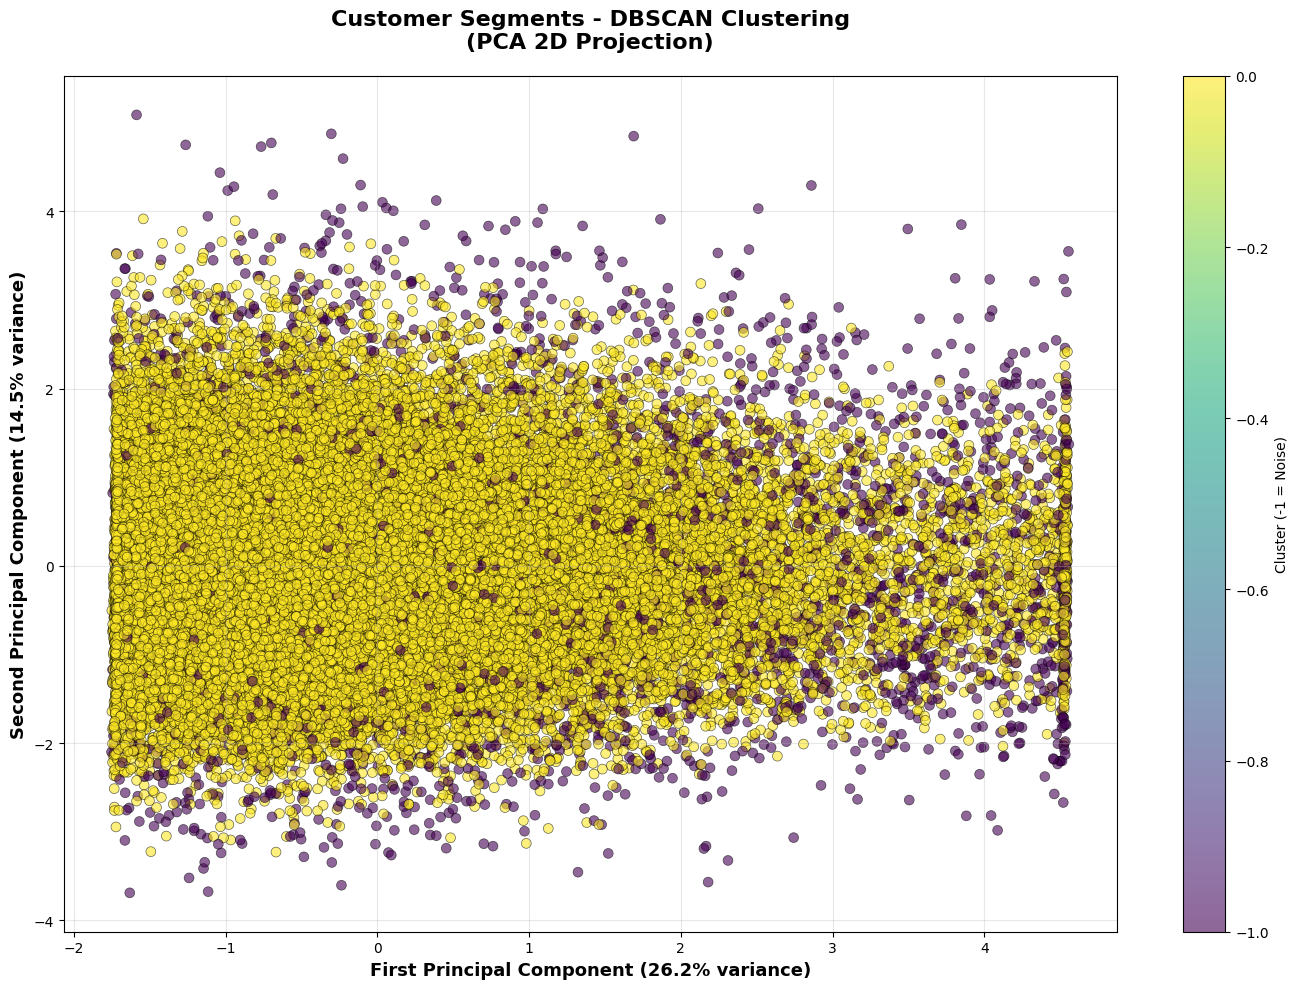


✅ Saved: visualization/dbscan_clusters_pca.png


In [14]:
# 2D Visualization with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(14, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=df['DBSCAN_Cluster'], 
                     cmap='viridis', 
                     alpha=0.6, 
                     s=50,
                     edgecolors='black',
                     linewidth=0.5)

plt.colorbar(scatter, label='Cluster (-1 = Noise)')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)', 
           fontsize=13, fontweight='bold')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)', 
           fontsize=13, fontweight='bold')
plt.title('Customer Segments - DBSCAN Clustering\n(PCA 2D Projection)', 
          fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualization/dbscan_clusters_pca.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✅ Saved: visualization/dbscan_clusters_pca.png")